# Analyzing Kaggle Survey 2020 in a structured way

Yao-Jen Kuo <yaojenkuo@datainpoint.com> from [DATAINPOINT](https://datainpoint.substack.com/about)

## Prerequisite libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## TL; DR

In this notebook, we define a class `KaggleSurvey2020` that is able to help us analyze the Kaggle Survey 2020 in a more structured way and shows how to conduct data analysis with OOP besides using the traditional procedural programming way.

## Pain point

The original Kaggle Survey 2020 data contains 354 columns with 47 questions combined with multiple choice and multiple selection questions. It is definitely painful and tedious to explore without the aids of re-usable codes like functions or classes.

## The `KaggleSurvey2020` class

We will define 3 major methods of `KaggleSurvey2020` to analyze both survey responses and questions.

1. The `generate_unique_questions` method: Returns a dataframe that maps question numbers to their descriptions and questions types.
2. The `summarize_response(question_index)` method: Returns an aggregation summary of a given question. For a multiple choice problem (only a single choice can be selected) this method returns a series of percentages. As for a multiple selection problem (multiple choices can be selected) this method return a series of value counts.
3. The `plot_summary(question_index)` method: Plots a horizontal bar plot that illustrates the aggregation summary of a given question.

In [2]:
class KaggleSurvey2020:
    """
    This class helps us analyze the Kaggle Survey 2020 with ease.
    See https://www.kaggle.com/c/kaggle-survey-2020
    Args:
        csv_file (str): Specify the file path of kaggle_survey_2020_responses.csv.
    """
    def __init__(self, csv_file):
        self._csv_file = csv_file
        # import survey responses
        survey_response = pd.read_csv(self._csv_file, skiprows=[1])
        survey_response = survey_response.drop('Time from Start to Finish (seconds)', axis=1)
        # import survey questions
        first_2_rows = pd.read_csv(self._csv_file, nrows=1)
        question_desc = first_2_rows.values.ravel()[1:]
        question_index = first_2_rows.columns[1:]
        questions_ser = pd.Series(question_desc, index=question_index)
        self._survey_response = survey_response
        self._questions_ser = questions_ser
    def generate_questions(self):
        """
        This function returns the DataFrame of questions.
        """
        question_indices = [l[0] + l[1] if len(l) > 1 else l[0] for l in self._questions_ser.index.str.split("_")]
        question_indices = [s.replace('Part', '') if 'Part' in s else s for s in question_indices]
        question_indices = [s.replace('OTHER', '') if 'OTHER' in s else s for s in question_indices]
        questions = pd.DataFrame()
        questions['question_index'] = question_indices
        questions['question_desc'] = self._questions_ser.values
        return questions
    def generate_unique_questions(self):
        """
        This function returns the DataFrame of unique questions.
        """
        questions = self.generate_questions()
        question_indices = questions['question_index'].values
        question_descs = [l[0] for l in self._questions_ser.str.split(' - ')]
        # Collecting unique questions indices and descriptions
        unique_question_indices = []
        unique_question_descs = []
        for qi, qd in zip(question_indices, question_descs):
            if qi not in unique_question_indices:
                unique_question_indices.append(qi)
            if qd not in unique_question_descs:
                unique_question_descs.append(qd)
        # Categorizing question type
        question_types = ['multiple selection' if 'Select all that apply' in s else 'multiple choice' for s in unique_question_descs]
        unique_questions = pd.DataFrame()
        unique_questions['question_index'] = unique_question_indices
        unique_questions['question_desc'] = unique_question_descs
        unique_questions['question_type'] = question_types
        return unique_questions
    def summarize_response(self, question_index):
        """
        This function returns the summary of a given question.
        Args:
            question_index (str): Specify the question, e.g. 'Q1' for Question 1, 'Q26A' for Question 26-A.
        """
        questions = self.generate_questions()
        column_iloc = questions[questions['question_index'] == question_index].index
        ith_question = self._survey_response.iloc[:, column_iloc]
        unique_questions = self.generate_unique_questions()
        ith_unique_question = unique_questions[unique_questions['question_index'] == question_index]
        question_desc = ith_unique_question['question_desc'].values[0]
        print(question_desc)
        # Use simple value_counts for multiple choice questions
        if column_iloc.size == 1:
            summary = ith_question[question_index].value_counts(normalize=True).sort_values()
        # Use iteration for multiple selection questions
        else:
            freq_counts = dict()
            for col in ith_question.columns:
                ser = ith_question[col]
                ser_value_counts = ser.value_counts()
                k, v = ser_value_counts.index[0], ser_value_counts.values[0]
                freq_counts[k] = v
            summary = pd.Series(freq_counts).sort_values()
        return summary
    def plot_summary(self, question_index):
        """
        This function plots the bar plot of a given question.
        Args:
            question_index (str): Specify the question, e.g. 'Q1' for Question 1, 'Q26A' for Question 26-A.
        """
        fig = plt.figure()
        axes = plt.axes()
        response_ser = self.summarize_response(question_index)
        # Showing only top 10 categories if there are too many.
        if response_ser.size > 10:
            print("Too many categories, only showing the top 10.")
            top_ten = response_ser[-10:]
            y = top_ten.index
            width = top_ten.values
        else:
            y = response_ser.index
            width = response_ser.values
        # Highlight top 3 with red
        colors = ['c' for _ in range(y.size)]
        colors[-3:] = ['r', 'r', 'r']
        axes.barh(y, width, color=colors)
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.tick_params(length=0)
        unique_questions = self.generate_unique_questions()
        ith_unique_question = unique_questions[unique_questions['question_index'] == question_index]
        question_desc = ith_unique_question['question_desc'].values[0]
        axes.set_title(question_desc)
        plt.show()

## Summarizing survey questions

The Kaggle Survey 2020 contains two types of question: multiple choice questions (only a single choice can be selected) and multiple selection questions (multiple choices can be selected). We can generate an overview of Kaggle Survey 2020 questions with our pre-defined class.

In [3]:
csv_file = 'kaggle_survey_2020_responses.csv'
ks = KaggleSurvey2020(csv_file)
unique_questions = ks.generate_unique_questions()
unique_questions.head()

,question_index,question_desc,question_type
0,Q1,What is your age (# years)?,multiple choice
1,Q2,What is your gender?,multiple choice
2,Q3,In which country do you currently reside?,multiple choice
3,Q4,What is the highest level of formal education ...,multiple choice
4,Q5,Select the title most similar to your current ...,multiple choice


In [4]:
unique_questions.tail()

,question_index,question_desc,question_type
42,Q29B,Which of the following big data products (rela...,multiple selection
43,Q31B,Which of the following business intelligence t...,multiple selection
44,Q33B,Which categories of automated machine learning...,multiple selection
45,Q34B,Which specific automated machine learning tool...,multiple selection
46,Q35B,"In the next 2 years, do you hope to become mor...",multiple selection


In [5]:
n_questions = unique_questions.shape[0]
question_summary = unique_questions['question_type'].value_counts()
n_multiple_choice = question_summary['multiple choice']
n_multiple_selection = question_summary['multiple selection']
print(question_summary)

multiple selection    28
multiple choice       19
Name: question_type, dtype: int64


In [6]:
print("There are {} multiple choices and {} multiple selections among {} questions.".format(n_multiple_choice, n_multiple_selection, n_questions))

There are 19 multiple choices and 28 multiple selections among 47 questions.


## Summarizing survey responses

We are able to summarize each question (no matter it is a multiple choice or a multiple selection) with the method `summarize_response(question_index)`. Take 2 multiple choice questions as examples, we can summarize the responses with a series of percentages.

In [7]:
# Select the title most similar to your current role (or most recent title if retired):
ks.summarize_response('Q5')

Select the title most similar to your current role (or most recent title if retired):


DBA/Database Engineer        0.006484
Statistician                 0.015044
Data Engineer                0.022670
Product/Project Manager      0.035898
Business Analyst             0.041396
Machine Learning Engineer    0.056129
Research Scientist           0.060902
Data Analyst                 0.076516
Currently not employed       0.085698
Other                        0.090107
Software Engineer            0.102091
Data Scientist               0.138818
Student                      0.268247
Name: Q5, dtype: float64

In [8]:
# What programming language would you recommend an aspiring data scientist to learn first?
ks.summarize_response('Q8')

What programming language would you recommend an aspiring data scientist to learn first?


Swift         0.000954
Bash          0.001459
None          0.004545
Javascript    0.004938
Julia         0.006790
Other         0.008473
Java          0.009371
MATLAB        0.010942
C             0.016890
C++           0.018237
SQL           0.047640
R             0.070647
Python        0.799113
Name: Q8, dtype: float64

Take other 2 multiple selection questions as examples, we can summarize the responses with a series of value counts.

In [9]:
# What programming languages do you use on a regular basis? (Select all that apply)
ks.summarize_response('Q7')

What programming languages do you use on a regular basis? (Select all that apply)


Swift           198
None            206
Julia           262
Bash           1776
Other          1945
MATLAB         2217
Javascript     2995
C              3315
Java           3367
C++            3827
R              4277
SQL            7535
Python        15530
dtype: int64

In [10]:
# Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply)
ks.summarize_response('Q9')

Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply)


None                                               386
Other                                             1162
  Vim / Emacs                                     1502
 MATLAB                                           1604
Visual Studio                                     2445
  Sublime Text                                    2452
  Notepad++                                       3132
  Spyder                                          3290
 RStudio                                          3826
 PyCharm                                          5099
Visual Studio Code (VSCode)                       5873
Jupyter (JupyterLab, Jupyter Notebooks, etc)     11211
dtype: int64

## Plotting survey responses

Besides showing a series of percentages/value counts, we can also plot a horizontal bar plot based on the series by calling the `plot_summary(question_index)` method. If there are too many categories, this method only shows the top 10 most categories.

Select any activities that make up an important part of your role at work: (Select all that apply)


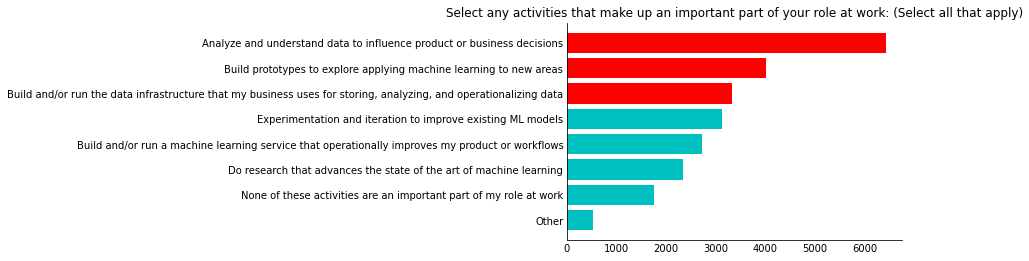

In [11]:
ks.plot_summary('Q23')

Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply)
Too many categories, only showing the top 10.


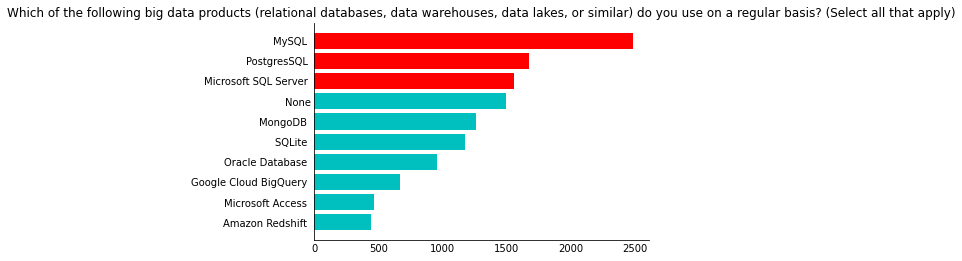

In [12]:
ks.plot_summary('Q29A')

## Conclusion

The notebook users have long been criticized for not writing re-usable codes. In this notebook, we incorporate object-oriented programming. We are able to demonstrate how to conduct reproducible exploratory analysis with summaries of percentage/value counts and plots by instantiating the `KaggleSurvey2020` class. If you also find it convenient, it is time to add some OO flavor into your own notebook!

The `KaggleSurvey2020` class can be imported from ks2020.py via the following codes.

In [13]:
from ks2020 import KaggleSurvey2020

csv_file = 'kaggle_survey_2020_responses.csv'
ks = KaggleSurvey2020(csv_file)
type(ks)

ks2020.KaggleSurvey2020